In [ ]:
# Full clear function
def clear_all():
    globals().clear()
    import gc, tensorflow as tf
    tf.keras.backend.clear_session()
    gc.collect()

clear_all()


Saving dataset_split.zip to dataset_split.zip
Found 2100 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 106s 620ms/step - accuracy: 0.5756 - loss: 0.6718 - val_accuracy: 0.8111 - val_loss: 0.5027 - learning_rate: 1.0000e-04
Epoch 2/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 60s 456ms/step - accuracy: 0.7206 - loss: 0.5771 - val_accuracy: 0.8133 - val_loss: 0.4348 - learning_rate: 1.0000e-04
Epoch 3/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 58s 439ms/step - accuracy: 0.7167 - loss: 0.5621 - val_accuracy: 0.8022 - val_loss: 0.4191 - learning_rate: 1.0000e-04
Epoch 4/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 60s 449ms/step - accuracy: 0.7747 - loss: 0.5129 - val_accuracy: 0.8089 - val_loss: 0.4013 - learning_rate: 1.0000e-04
Epoch 5/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 59s 450ms/step - accuracy: 0.7394 - loss: 0.5553 - val_accuracy: 0.8044 - val_loss: 0.4239 - learning_rate: 1.0000e-04
Epoch 6/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 59s 449ms/step - accuracy: 0.7417 - loss: 0.5277 - val_accuracy: 0.8000 - val_loss: 0.4130 - learning_rate: 1.0000e-04
Epoch 7/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 41

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

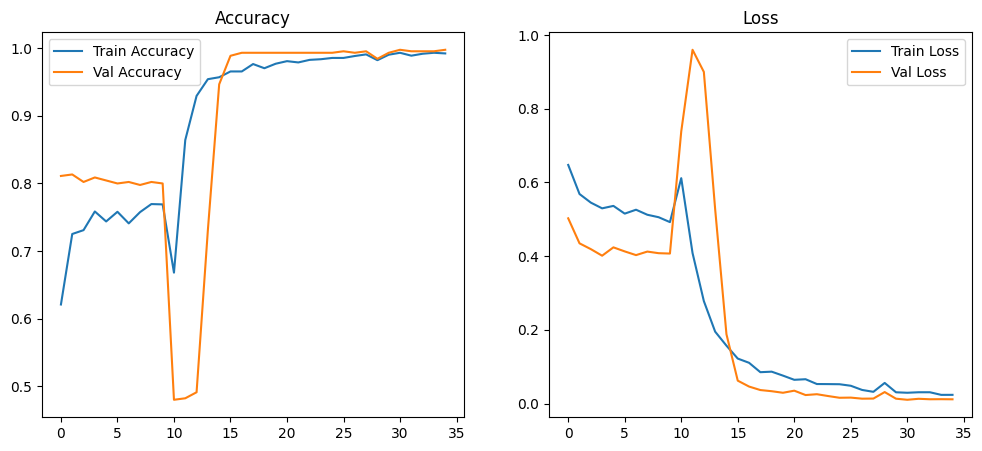

In [ ]:
                       # EfficientNetB0 Model



# ✅ STEP 1: লাইব্রেরি ইমপোর্ট
import os, zipfile, cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0  # EfficientNetB0 ব্যবহার করা হয়েছে
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

# ✅ STEP 2: Dataset Extract
uploaded = files.upload()
zip_filename = next(iter(uploaded))
extract_path = "/content/dataset_split"
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# ✅ STEP 3: Preprocessing function to enhance blurry images
def enhance_image(image):
    # Convert to LAB and apply CLAHE
    lab = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    enhanced_lab = cv2.merge((cl, a, b))
    enhanced_rgb = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)

    # Apply sharpening kernel
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(enhanced_rgb, -1, kernel)

    return sharpened / 255.0

# ✅ STEP 4: ImageDataGenerator with custom preprocessing
IMAGE_SIZE = (300, 300)  # ইমেজ সাইজ কমানো হলো
BATCH_SIZE = 16  # ব্যাচ সাইজ কমানো হলো

train_datagen = ImageDataGenerator(
    preprocessing_function=enhance_image,
    rotation_range=40,
    zoom_range=0.4,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(preprocessing_function=enhance_image)

train_generator = train_datagen.flow_from_directory(
    os.path.join(extract_path, 'train'), target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
val_generator = val_test_datagen.flow_from_directory(
    os.path.join(extract_path, 'val'), target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(extract_path, 'test'), target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)

# ✅ STEP 5: Compute Class Weights
labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))

# ✅ STEP 6: EfficientNetB0 Model Architecture (Updated)
input_tensor = Input(shape=(300, 300, 3))  # ইমেজ সাইজ কমানো হলো
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)  # EfficientNetB0 ব্যবহার করা হয়েছে

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_tensor, outputs=output)

# ✅ STEP 7: Compile & Callbacks
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(patience=6, restore_best_weights=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
checkpoint = ModelCheckpoint("best_fire_model.keras", monitor='val_accuracy', save_best_only=True)

# ✅ STEP 8: Training Phase 1
history1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights
)

# ✅ STEP 9: Fine-tune Unfrozen Model
for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights
)

# ✅ STEP 10: Evaluate
loss, accuracy = model.evaluate(test_generator)
print(f"✅ Final Test Accuracy: {accuracy * 100:.2f}%")

# ✅ STEP 11: Save Model
model.save("/content/final_fire_model_blur_aware.keras")
files.download("/content/final_fire_model_blur_aware.keras")

# ✅ STEP 12: Plot Training
def plot_training(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.legend(); plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.legend(); plt.title('Loss')

    plt.show()

plot_training(history1, history2)


Saving dataset_split.zip to dataset_split.zip
Found 2100 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 450 images belonging to 2 classes.


/tmp/ipython-input-48-2367462773.py:68: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.6678 - loss: 0.7559 - val_accuracy: 0.9267 - val_loss: 0.2066 - learning_rate: 1.0000e-04
Epoch 2/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.8928 - loss: 0.2738 - val_accuracy: 0.9667 - val_loss: 0.1034 - learning_rate: 1.0000e-04
Epoch 3/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.9351 - loss: 0.1844 - val_accuracy: 0.9844 - val_loss: 0.0573 - learning_rate: 1.0000e-04
Epoch 4/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.9434 - loss: 0.1462 - val_accuracy: 0.9889 - val_loss: 0.0422 - learning_rate: 1.0000e-04
Epoch 5/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.9530 - loss: 0.1193 - val_accuracy: 0.9956 - val_loss: 0.0339 - learning_rate: 1.0000e-04
Epoch 6/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.9460 - loss: 0.1271 - val_accuracy: 0.9911 - val_loss: 0.0322 - learning_rate: 1.0000e-04
Epoch 7/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - acc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


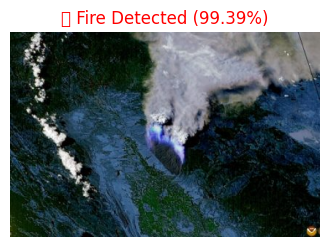

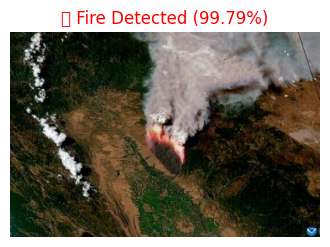

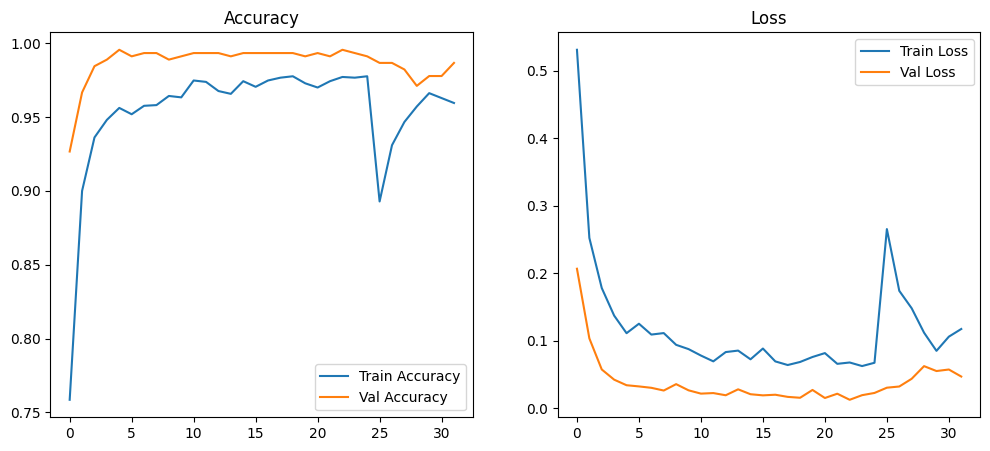

In [ ]:
       # Use MobilNetV2 Model



# ✅ STEP 1: লাইব্রেরি ইমপোর্ট
import os, zipfile, cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2  # MobileNetV2 ব্যবহার করা হয়েছে
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

# ✅ STEP 2: Dataset Extract
uploaded = files.upload()
zip_filename = next(iter(uploaded))
extract_path = "/content/dataset_split"
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# ✅ STEP 3: Preprocessing function to enhance blurry images
def enhance_image(image):
    lab = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    enhanced_lab = cv2.merge((cl, a, b))
    enhanced_rgb = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    sharpened = cv2.filter2D(enhanced_rgb, -1, kernel)
    return sharpened / 255.0

# ✅ STEP 4: ImageDataGenerator with custom preprocessing
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    preprocessing_function=enhance_image,
    rotation_range=40,
    zoom_range=0.4,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(preprocessing_function=enhance_image)

train_generator = train_datagen.flow_from_directory(
    os.path.join(extract_path, 'train'), target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
val_generator = val_test_datagen.flow_from_directory(
    os.path.join(extract_path, 'val'), target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(extract_path, 'test'), target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)

# ✅ STEP 5: Compute Class Weights
labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))

# ✅ STEP 6: MobileNetV2 Model Architecture
input_tensor = Input(shape=(256, 256, 3))
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_tensor, outputs=output)

# ✅ STEP 7: Compile & Callbacks
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(patience=6, restore_best_weights=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
checkpoint = ModelCheckpoint("best_fire_model_mobilenetv2.keras", monitor='val_accuracy', save_best_only=True)

# ✅ STEP 8: Training Phase 1
history1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights
)

# ✅ STEP 9: Fine-tune Unfrozen Model
for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights
)

# ✅ STEP 10: Evaluate
loss, accuracy = model.evaluate(test_generator)
print(f"✅ Final Test Accuracy: {accuracy * 100:.2f}%")

# ✅ STEP 11: Save Model
model.save("/content/final_fire_model_mobilenetv2.keras")
files.download("/content/final_fire_model_mobilenetv2.keras")

# ✅ STEP 12: Plot Training
def plot_training(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.legend(); plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.legend(); plt.title('Loss')

    plt.show()

plot_training(history1, history2)


Saving dataset_split.zip to dataset_split.zip
Found 2100 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 457s 4s/step - accuracy: 0.8955 - loss: 0.2873 - val_accuracy: 0.5200 - val_loss: 0.7614 - learning_rate: 1.0000e-04
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.9968 - loss: 0.0205 - val_accuracy: 0.5200 - val_loss: 1.0538 - learning_rate: 1.0000e-04
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.9957 - loss: 0.0139 - val_accuracy: 0.5200 - val_loss: 1.0371 - learning_rate: 1.0000e-04
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.9935 - loss: 0.0177 - val_accuracy: 0.5222 - val_loss: 0.5796 - learning_rate: 1.0000e-04
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.9982 - loss: 0.0117 - val_accuracy: 0.5200 - val_loss: 0.4141 - learning_rate: 1.0000e-04
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.9983 - loss: 0.0067 - val_accuracy: 0.9533 - val_loss: 0.3498 - learning_rate: 1.0000e-04
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.9982 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

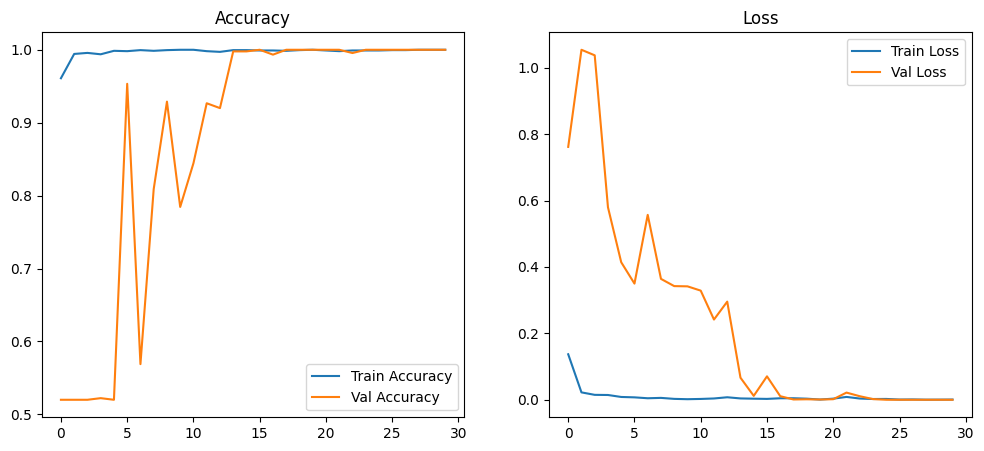

In [ ]:
                # Ensemble Model [ResNet50 ModeL+ EfficientNetB3 ModeL)



# ✅ STEP 1: Library Imports
import os, zipfile, cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Average
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

# ✅ STEP 2: Upload & Extract Dataset
uploaded = files.upload()
zip_filename = next(iter(uploaded))
extract_path = "/content/dataset_split"
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# ✅ STEP 3: Preprocessing (CLAHE + Sharpen)
def enhance_image(image):
    lab = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    enhanced_lab = cv2.merge((cl, a, b))
    enhanced_rgb = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(enhanced_rgb, -1, kernel)
    return sharpened / 255.0

# ✅ STEP 4: Image Generator
IMAGE_SIZE = (350, 350)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=enhance_image,
    rotation_range=40,
    zoom_range=0.4,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(preprocessing_function=enhance_image)

train_generator = train_datagen.flow_from_directory(
    os.path.join(extract_path, 'train'), target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
val_generator = val_test_datagen.flow_from_directory(
    os.path.join(extract_path, 'val'), target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(extract_path, 'test'), target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)

# ✅ STEP 5: Class Weights
labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))

# ✅ STEP 6: Define Two Individual Models

# 🔸 ResNet50 Branch
def build_resnet_branch():
    input_tensor = Input(shape=(350, 350, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_tensor, outputs=x)
    return model

# 🔸 EfficientNetB3 Branch
def build_efficientnet_branch():
    input_tensor = Input(shape=(350, 350, 3))
    base_model = EfficientNetB3(weights='imagenet', include_top=False, input_tensor=input_tensor)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_tensor, outputs=x)
    return model

# ✅ STEP 7: Ensemble Model
input_layer = Input(shape=(350, 350, 3))

resnet_branch = build_resnet_branch()(input_layer)
efficientnet_branch = build_efficientnet_branch()(input_layer)

# Average predictions from both models
avg_output = Average()([resnet_branch, efficientnet_branch])

ensemble_model = Model(inputs=input_layer, outputs=avg_output)

# ✅ STEP 8: Compile and Callbacks
ensemble_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(patience=6, restore_best_weights=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
checkpoint = ModelCheckpoint("best_ensemble_model.keras", monitor='val_accuracy', save_best_only=True)

# ✅ STEP 9: Train
history = ensemble_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights
)

# ✅ STEP 10: Evaluate
loss, accuracy = ensemble_model.evaluate(test_generator)
print(f"✅ Final Test Accuracy (Ensemble): {accuracy * 100:.2f}%")

# ✅ STEP 11: Save Model
ensemble_model.save("/content/final_ensemble_fire_model.keras")
files.download("/content/final_ensemble_fire_model.keras")

# ✅ STEP 12: Plot Training Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend(); plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')

plt.show()



In [ ]:
# Fire prediction General Code



# ✅ STEP 1: লাইব্রেরি ইমপোর্ট 🧠
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import files
import os
import random
from IPython.display import Markdown, display, Audio
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ✅ STEP 2: মডেল লোড 🚀
print("🔁 মডেল লোড করা হচ্ছে...")
model = load_model("/content/final_ensemble_fire_model.keras")
print("✅ মডেল সফলভাবে লোড হয়েছে!")

# ✅ STEP 3: ছবি আপলোড 📤
print("📷 ছবি আপলোড করুন...")
uploaded = files.upload()
image_paths = list(uploaded.keys())

# ✅ STEP 4: Preprocessing Function 🔧
def preprocess_image(image, size=(350, 350), augment=False):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, size)

    if augment:
        if random.random() < 0.5:
            image = cv2.flip(image, 1)
        if random.random() < 0.3:
            image = cv2.flip(image, 0)
        if random.random() < 0.4:
            angle = random.choice([-15, -10, -5, 5, 10, 15])
            h, w = image.shape[:2]
            M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
            image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)
        if random.random() < 0.4:
            hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            factor = random.uniform(0.7, 1.3)
            hsv[:, :, 2] = np.clip(hsv[:, :, 2] * factor, 0, 255)
            image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # CLAHE + Sharpen
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    image_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(image_clahe, -1, kernel)

    image_normalized = sharpened / 255.0
    return np.expand_dims(image_normalized, axis=0)

# ✅ STEP 5: TTA Prediction Function 🔁
THRESHOLD = 0.6
results = []

def tta_prediction(image_path, tta_times=15):
    original = cv2.imread(image_path)
    predictions = []

    for _ in range(tta_times):
        input_img = preprocess_image(original.copy(), augment=True)
        pred = model.predict(input_img, verbose=0)[0][0]
        predictions.append(pred)

    avg_prediction = np.mean(predictions)
    return avg_prediction, original

# ✅ STEP 6: Prediction with Display & Sound 🎵
true_labels = []  # 1 = fire, 0 = non-fire
pred_labels = []

for path in image_paths:
    prediction, original_image = tta_prediction(path)

    if prediction >= THRESHOLD:
        label = "🔥 Fire Detected"
        color = 'red'
        pred_labels.append(1)
        # 🔊 Alert sound
        display(Audio("https://actions.google.com/sounds/v1/alarms/alarm_clock.ogg", autoplay=True))
    else:
        label = "✅ No Fire Detected"
        color = 'green'
        pred_labels.append(0)

    # 👁️ Image Display
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"{label} ({prediction*100:.2f}%)", color=color)
    plt.show()

    results.append((path, prediction, label))

    # For Confusion Matrix demo, assume filenames tell the true label
    if "fire" in path.lower():
        true_labels.append(1)
    else:
        true_labels.append(0)

# ✅ STEP 7: Gorgeous Summary Print ✨
def print_gorgeous_summary(results):
    display(Markdown("## 📊✨ **Prediction Summary Report** ✨📊\n"))
    for img_name, score, label in results:
        conf = f"{score*100:.2f}%"
        emoji = "🔥" if "Fire" in label else "🟢"
        markdown_text = f"- 🖼️ `{img_name}` → **{emoji} {label}** | **Confidence:** `{conf}` 💯"
        display(Markdown(markdown_text))

print_gorgeous_summary(results)

# ✅ STEP 8: Confusion Matrix (if multiple images) 📉
if len(results) >= 2:
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fire", "Fire"])
    plt.figure(figsize=(6, 5))
    disp.plot(cmap="Oranges")
    plt.title("🔥 Confusion Matrix 🔥")
    plt.grid(False)
    plt.show()


🔁 মডেল লোড করা হচ্ছে...
✅ মডেল সফলভাবে লোড হয়েছে!
📷 ছবি আপলোড করুন...


TypeError: 'NoneType' object is not subscriptable

In [ ]:
    # Make: Gradio App


# ✅ STEP 1: প্রয়োজনীয় লাইব্রেরি ইন্সটল
!pip install -q gradio

# ✅ STEP 2: লাইব্রেরি ইমপোর্ট
import gradio as gr
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import random

# ✅ STEP 3: মডেল লোড
model = load_model("/content/final_ensemble_fire_model.keras")

# ✅ STEP 4: প্রিপ্রসেসিং ফাংশন
def preprocess_image(image, size=(350, 350), augment=False):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, size)

    if augment:
        if random.random() < 0.5:
            image = cv2.flip(image, 1)
        if random.random() < 0.3:
            image = cv2.flip(image, 0)
        if random.random() < 0.4:
            angle = random.choice([-15, -10, -5, 5, 10, 15])
            h, w = image.shape[:2]
            M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1)
            image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)
        if random.random() < 0.4:
            hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            factor = random.uniform(0.7, 1.3)
            hsv[:, :, 2] = np.clip(hsv[:, :, 2] * factor, 0, 255)
            image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    image_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(image_clahe, -1, kernel)

    image_normalized = sharpened / 255.0
    return np.expand_dims(image_normalized, axis=0)

# ✅ STEP 5: TTA Prediction ফাংশন
def tta_prediction(image, tta_times=15):
    original = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    predictions = []

    for _ in range(tta_times):
        input_img = preprocess_image(original.copy(), augment=True)
        pred = model.predict(input_img, verbose=0)[0][0]
        predictions.append(pred)

    avg_prediction = np.mean(predictions)
    return avg_prediction, original

# ✅ STEP 6: Gradio ফাংশন
def predict_fire(image):
    prediction, original_image = tta_prediction(image, tta_times=15)

    if prediction >= 0.6:
        label = "🔥 Fire Detected"
        color = 'red'
    else:
        label = "✅ No Fire Detected"
        color = 'green'

    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"{label} ({prediction*100:.2f}%)", color=color)
    plt.show()

    return f"{label} | Confidence: {prediction*100:.2f}%"

# ✅ STEP 7: Gradio UI বানানো
interface = gr.Interface(
    fn=predict_fire,
    inputs=gr.Image(type="pil", label="📤 Upload Image"),
    outputs=gr.Textbox(label="📊 Prediction Result"),
    title="🔥 Fire Detection Model",
    description="Upload an image to detect 🔥 fire or ✅ no fire.",
    live=True
)

# ✅ STEP 8: অ্যাপ চালু (display bug এড়াতে _ = ব্যবহার করুন)
_ = interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6223b2855cde061b17.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
